# Image Classification Using ResNet18
Source: 
* PyTorch tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* https://github.com/ndb796/Face-Gender-Classification-PyTorch/blob/main/Face_Gender_Classification_using_Transfer_Learning_with_ResNet18.ipynb

Other useful references:
* https://github.com/spmallick/learnopencv/blob/master/Image-Classification-in-PyTorch/image_classification_using_transfer_learning_in_pytorch.ipynb
* https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/


Dataset: Disney

Structure:

```bash
├── dataset
│   ├── train
│   │   ├── animal
|   |   |   ├── female
│   │   |   └── male
|   |   ├── human
|   |   |   ├── female
│   │   |   └── male
|   |   ├── humanoid
|   |   |   ├── female
│   │   |   └── male
|   |   ├── machine
|   |   |   ├── female
│   │   |   └── male
│   └── val
│   │   ├── animal
|   |   |   ├── female
│   │   |   └── male
|   |   ├── human
|   |   |   ├── female
│   │   |   └── male
|   |   ├── humanoid
|   |   |   ├── female
│   │   |   └── male
|   |   ├── machine
            ├── female
            └── male
```

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
import glob as gb
import time
import copy

import torch.backends.cudnn as cudnn
# cudnn.benchmark = True  # Disable for evaluation as can noticeably affect the accuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Fetch dataset for classification
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_3D_human_train_with_background_portraits.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_3D_human_train_portraits.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/disney_2000-present_portraits.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/3D_portraits.zip > /dev/null
#!unzip /content/drive/MyDrive/machine_learning/datasets/3D_faces.zip > /dev/null
!unzip /content/drive/MyDrive/machine_learning/datasets/2D_3D_portraits.zip > /dev/null
!unzip /content/drive/MyDrive/machine_learning/datasets/icartoonface_rectrain.zip > /dev/null

### Prepare Data

In [ ]:
# Create "dataset" dir
for i in ['train', 'val']:
  for char_style in ["human", "humanoid", "animal", "machine", "all"]:
    for gender in ['male', 'female']: # 'background'
      dir = f'dataset/{i}/{char_style}/{gender}'
      # delete folder contents if already exist
      if os.path.exists(dir):
        shutil.rmtree(dir)
      os.makedirs(dir)

# Create "output" dir
dir = 'output'
# delete folder contents if already exist
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

In [ ]:
# Set paths
DATASET_PATH = "2D_3D_portraits/*"
DST_PATH = "/content/dataset"

# change dir name from test to val
!mv /content/2D_3D_portraits/2D/test /content/2D_3D_portraits/2D/val > /dev/null
!mv /content/2D_3D_portraits/3D/test /content/2D_3D_portraits/3D/val > /dev/null

In [ ]:
# Choose an equal number of males and females for training and validation
for d in ["train", "val"]:
  for char_style in ["human", "humanoid", "animal", "machine"]: # any or all of "huam", "humanoid", "animal", "machine"
    females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/male/*.jpg"))]
    # bg = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/background/*.jpg"))]

    # Randomly shuffle all images and select equal number of faces
    import random
    random.seed(0)
    random.shuffle(females)
    random.shuffle(males)

    if len(females) < len(males):
      males_subset = random.sample(males, len(females))
      males = males_subset
    else:
      females_subset = random.sample(females, len(males))
      females = females_subset

    # Copy files into train and val folders
    for gender, gender_list in {'female':females, 'male':males}.items(): # 'background':bg
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.copyfile(full_fname, f"{DST_PATH}/{d}/{char_style}/{gender}/{fname}") # sepaarte char style folders
        shutil.copyfile(full_fname, f"{DST_PATH}/{d}/all/{gender}/{fname}") # all char styles together

In [ ]:
# Get number of female and male portraits
def get_gender_dic(char_style):
  gender_dist = {}
  for d in ["train", "val"]:
    females = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/male/*.jpg"))]
    # bg = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/background/*.jpg"))]
    gender_dist[d] = {"total": len(males + females), "females": len(females), "males": len(males)} # "background": len(bg) 
  return gender_dist


gender_dist_human = get_gender_dic("human")
gender_dist_humanoid = get_gender_dic("humanoid")
gender_dist_animal = get_gender_dic("animal")
gender_dist_machine = get_gender_dic("machine")
gender_dist_all = get_gender_dic("all")

print(f"human: {gender_dist_human}")
print(f"humanoid: {gender_dist_humanoid}")
print(f"animal: {gender_dist_animal}")
print(f"machine: {gender_dist_machine}")
print(f"all: {gender_dist_all}")

human: {'train': {'total': 5566, 'females': 2783, 'males': 2783}, 'val': {'total': 1398, 'females': 699, 'males': 699}}
humanoid: {'train': {'total': 458, 'females': 229, 'males': 229}, 'val': {'total': 484, 'females': 242, 'males': 242}}
animal: {'train': {'total': 1244, 'females': 622, 'males': 622}, 'val': {'total': 898, 'females': 449, 'males': 449}}
machine: {'train': {'total': 70, 'females': 35, 'males': 35}, 'val': {'total': 10, 'females': 5, 'males': 5}}
all: {'train': {'total': 7338, 'females': 3669, 'males': 3669}, 'val': {'total': 2790, 'females': 1395, 'males': 1395}}


### Misc Code for Mini Experiments

#### Remove encanto, frozen, robinsons from training

In [ ]:
# OPTIONAL: depending on the dataset, it might be necessary to remove encanto, 
# frozen and robinsons from training set

fem = os.listdir("dataset/train/female")
mal = os.listdir("dataset/train/male")
for f in fem:
  if "encanto" in f:
    os.remove(f"dataset/train/female/{f}")
  elif "frozen" in f:
    os.remove(f"dataset/train/female/{f}")
  elif "robinsons" in f:
    os.remove(f"dataset/train/female/{f}")

for f in mal:
  if "encanto" in f:
    os.remove(f"dataset/train/male/{f}")
  elif "frozen" in f:
    os.remove(f"dataset/train/male/{f}")
  elif "robinsons" in f:
    os.remove(f"dataset/train/male/{f}")

#### Mislabelled females

In [ ]:
# OPTIONAL: check that model is learning gender features by mislabelling half the females
for i in ['train', 'val']:
  for j in ['male', 'female']:
    dir = f'dataset/{i}/{j}'
    # delete folder contents if already exist
    if os.path.exists(dir):
      shutil.rmtree(dir)
    os.makedirs(dir)

dir = 'output'
# delete folder contents if already exist
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

In [ ]:
DATASET_PATH = "/content/dataset_complete"
DST_PATH = "/content/dataset"

In [ ]:
for d in ["train"]:
  # Select all females
  all_females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/all/female/*.jpg"))]

  # Randomly shuffle all images
  import random
  random.seed(0)
  random.shuffle(all_females)

  # Split in half and mislabel half 'males'
  half = int(len(all_females)/2)
  females = all_females[:half]
  males = all_females[half:]

  # Copy files into train and val folders
  for gender, gender_list in {'female':females, 'male':males}.items():
    for full_fname in gender_list:
      fname = full_fname.split("/")[-1]
      shutil.copyfile(full_fname, f"{DST_PATH}/{d}/{gender}/{fname}")

In [ ]:
# Copy val over in its entirety
for d in ["val"]:
  females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/all/female/*.jpg"))]
  males = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/all/male/*.jpg"))]

  for gender, gender_list in {'female':females, 'male':males}.items():
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.copyfile(full_fname, f"{DST_PATH}/{d}/{gender}/{fname}")

In [ ]:
# Get number of female and male portraits
gender_dist = {}
for d in ["train", "val"]:
  females = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/female/*.jpg"))]
  males = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/male/*.jpg"))]
  gender_dist[d] = {"total": len(males + females), "females": len(females), "males": len(males)}
print(gender_dist)

{'train': {'total': 3669, 'females': 1834, 'males': 1835}, 'val': {'total': 2790, 'females': 1395, 'males': 1395}}


#### Look for Plateau Point

In [ ]:
DATASET_PATH = "/content/dataset"
DST_PATH = "/content/dataset_5000_3D"

In [ ]:
# Create dir
for i in ['train', 'val']:
  for char_style in ["all", "human", "humanoid", "animal", "machine"]:
    for gender in ['male', 'female']: # 'background'
      dir = f'{DST_PATH}/{i}/{char_style}/{gender}'
      # delete folder contents if already exist
      if os.path.exists(dir):
        shutil.rmtree(dir)
      os.makedirs(dir)

In [ ]:
# Create "output" dir
dir = 'output'
# delete folder contents if already exist
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

In [ ]:
# Copy val over in its entirety
for d in ["val"]:
  for char_style in ["all", "human", "humanoid", "animal", "machine"]:
    females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/male/*.jpg"))]

    for gender, gender_list in {'female':females, 'male':males}.items():
        for full_fname in gender_list:
          fname = full_fname.split("/")[-1]
          shutil.copyfile(full_fname, f"{DST_PATH}/{d}/{char_style}/{gender}/{fname}")

In [ ]:
# Chose an equal number of males and females for training
for d in ["train"]:
  for char_style in ["all", "human", "humanoid", "animal"]: # 'human', "humanoid", "animal", "machine"
    females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/{char_style}/male/*.jpg"))]

    # Randomly shuffle all images and select equal number of faces
    import random
    random.seed(0)
    random.shuffle(females)
    random.shuffle(males)

    size = min(2500,len(females)) # number of images for the class
    males_subset = random.sample(males, size)
    females_subset = random.sample(females, size)
    males = males_subset
    females = females_subset

    # Copy files into train folder
    for gender, gender_list in {'female':females, 'male':males}.items():
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.copyfile(full_fname, f"{DST_PATH}/{d}/{char_style}/{gender}/{fname}")

In [ ]:
# Get number of female and male portraits
def get_gender_dic(char_style):
  gender_dist = {}
  for d in ["train", "val"]:
    females = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/male/*.jpg"))]
    # bg = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/background/*.jpg"))]
    gender_dist[d] = {"total": len(males + females), "females": len(females), "males": len(males)} # "background": len(bg) 
  return gender_dist

gender_dist_all = get_gender_dic("all")
gender_dist_human = get_gender_dic("human")
gender_dist_humanoid = get_gender_dic("humanoid")
gender_dist_animal = get_gender_dic("animal")
gender_dist_machine = get_gender_dic("machine")

print(f"all: {gender_dist_all}")
print(f"human: {gender_dist_human}")
print(f"humanoid: {gender_dist_humanoid}")
print(f"animal: {gender_dist_animal}")
print(f"machine: {gender_dist_machine}")

all: {'train': {'total': 4402, 'females': 2201, 'males': 2201}, 'val': {'total': 1598, 'females': 799, 'males': 799}}
human: {'train': {'total': 3820, 'females': 1910, 'males': 1910}, 'val': {'total': 668, 'females': 334, 'males': 334}}
humanoid: {'train': {'total': 232, 'females': 116, 'males': 116}, 'val': {'total': 410, 'females': 205, 'males': 205}}
animal: {'train': {'total': 280, 'females': 140, 'males': 140}, 'val': {'total': 510, 'females': 255, 'males': 255}}
machine: {'train': {'total': 0, 'females': 0, 'males': 0}, 'val': {'total': 10, 'females': 5, 'males': 5}}


### Recognition potential

In [ ]:
# Move val images into train
for d in ["val"]:
  for char_style in ["human", "humanoid", "animal", "machine", "all"]:
    females = [f for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [f for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/male/*.jpg"))]

    for gender, gender_list in {'female':females, 'male':males}.items():
        for full_fname in gender_list:
          fname = full_fname.split("/")[-1]
          shutil.move(full_fname, f"{DST_PATH}/train/{char_style}/{gender}/{fname}")

In [ ]:
# Randomly pick 10% of train to serve as val recognition set
import random
for char_style in ["human", "humanoid", "animal", "machine", "all"]:
  females = [f for f in sorted(gb.glob(f"{DST_PATH}/train/{char_style}/female/*.jpg"))]
  males = [f for f in sorted(gb.glob(f"{DST_PATH}/train/{char_style}/male/*.jpg"))]

  f_10percent = random.sample(females, int(len(females)/10))
  m_10percent = random.sample(males, int(len(males)/10))

  for gender, gender_list in {'female':f_10percent, 'male':m_10percent}.items():
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.move(full_fname, f"{DST_PATH}/val/{char_style}/{gender}/{fname}")

In [ ]:
# Get number of female and male portraits
def get_gender_dic(char_style):
  gender_dist = {}
  for d in ["train", "val"]:
    females = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/female/*.jpg"))]
    males = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/male/*.jpg"))]
    # bg = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/background/*.jpg"))]
    gender_dist[d] = {"total": len(males + females), "females": len(females), "males": len(males)} # "background": len(bg) 
  return gender_dist


gender_dist_human = get_gender_dic("human")
gender_dist_humanoid = get_gender_dic("humanoid")
gender_dist_animal = get_gender_dic("animal")
gender_dist_machine = get_gender_dic("machine")
gender_dist_all = get_gender_dic("all")

print(f"human: {gender_dist_human}")
print(f"humanoid: {gender_dist_humanoid}")
print(f"animal: {gender_dist_animal}")
print(f"machine: {gender_dist_machine}")
print(f"all: {gender_dist_all}")

human: {'train': {'total': 6268, 'females': 3134, 'males': 3134}, 'val': {'total': 696, 'females': 348, 'males': 348}}
humanoid: {'train': {'total': 848, 'females': 424, 'males': 424}, 'val': {'total': 94, 'females': 47, 'males': 47}}
animal: {'train': {'total': 1928, 'females': 964, 'males': 964}, 'val': {'total': 214, 'females': 107, 'males': 107}}
machine: {'train': {'total': 72, 'females': 36, 'males': 36}, 'val': {'total': 8, 'females': 4, 'males': 4}}
all: {'train': {'total': 9116, 'females': 4558, 'males': 4558}, 'val': {'total': 1012, 'females': 506, 'males': 506}}


### Rectrain

In [ ]:
DATASET_PATH = "/content/icartoonface_rectrain"
DST_PATH = "/content/dataset"

for i in ['train', 'val']:
  for j in ['male', 'female']:
    dir = f"{DST_PATH}/{i}/{j}"
    # delete folder contents if already exist
    if os.path.exists(dir):
      shutil.rmtree(dir)
    os.makedirs(dir)

dir = 'output'
# delete folder contents if already exist
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)

In [ ]:
# desired annotations (e.g. western, usable etc.)
#!cp /content/drive/MyDrive/machine_learning/datasets/icartoonface_rectrain_annotations/instances_train_usable_10.json /content/icartoonface_rectrain/annotations/instances_train.json > /dev/null
#!cp /content/drive/MyDrive/machine_learning/datasets/icartoonface_rectrain_annotations/instances_val_usable_10.json /content/icartoonface_rectrain/annotations/instances_val.json > /dev/null
# western_usable
!cp /content/drive/MyDrive/machine_learning/datasets/icartoonface_rectrain_annotations/instances_train_western_usable.json /content/icartoonface_rectrain/annotations/instances_train.json > /dev/null
!cp /content/drive/MyDrive/machine_learning/datasets/icartoonface_rectrain_annotations/instances_val_western_usable.json /content/icartoonface_rectrain/annotations/instances_val.json > /dev/null

In [ ]:
# # Create a list of first 10 images of each character
# DATASET_PATH = "icartoonface_rectrain"
# females = [os.path.basename(f) for f in sorted(gb.glob(f"{DATASET_PATH}/train/female/*/*000000[0-9].jpg"))]
# males = [os.path.basename(f) for f in sorted(gb.glob(f"{DATASET_PATH}/train/male/*/*000000[0-9].jpg"))]

# print(f"Total: {len(males + females)}, Females: {len(females)}, Males: {len(males)}")

Total: 38120, Females: 19450, Males: 18670


In [ ]:
# # Choose an equal number of males and females for training and validation
# import random

# # Randomly shuffle all images and select equal number of faces
# random.seed(0)
# random.shuffle(females)
# random.shuffle(males)

# if len(females) < len(males):
#   males_subset = random.sample(males, len(females))
#   males = males_subset
# else:
#   females_subset = random.sample(females, len(males))
#   females = females_subset

# print(f"Total: {len(males + females)}, Females: {len(females)}, Males: {len(males)}")

Total: 37340, Females: 18670, Males: 18670


In [ ]:
# # Compose filepath
# female_fnames = []
# male_fnames = []
# for gender, gender_list in {'female':females, 'male':males}.items():
#   for fname in gender_list:
#     str_arr = fname.split("_")
#     character_id = "personai_icartoonface_rectrain_" + str_arr[3]
#     full_fname = "icartoonface_rectrain/train/" + gender + "/" + character_id + "/" + fname
#     if gender is 'female':
#       female_fnames.append(full_fname)
#     else:
#       male_fnames.append(full_fname)

# print(f"Total: {len(male_fnames + female_fnames)}, Females: {len(female_fnames)}, Males: {len(male_fnames)}")

Total: 37340, Females: 18670, Males: 18670


In [ ]:
# # 80% training and 20% validation
# total_per_gender = len(female_fnames)
# iloc_train = int(total_per_gender * 0.8)
# print(total_per_gender, iloc_train)

18670 14936


In [ ]:
# # Copy files into train and val folders
# for gender, gender_fnames in {'female':female_fnames, 'male':male_fnames}.items():
#   for fname in gender_fnames[:iloc_train]:
#     dst = fname.split("/")[-1]
#     shutil.copyfile(fname, "/content/dataset/train/" + gender + "/" + dst)

#   for fname in gender_fnames[iloc_train:]:
#     dst = fname.split("/")[-1]
#     shutil.copyfile(fname, "/content/dataset/val/" + gender + "/" + dst)

In [ ]:
import json

def get_dataset_dic(d):
  json_file = f"{DATASET_PATH}/annotations/instances_{d}.json"
  with open(json_file) as f:
    dataset_dict = json.load(f)
  return dataset_dict

train_dataset = get_dataset_dic("train")
val_dataset = get_dataset_dic("val")
print(f"Train images: {len(train_dataset)}, Val images: {len(val_dataset)}")

Train images: 19209, Val images: 1663


In [ ]:
def split_gender(dic):
  females = [portrait for portrait in dic if 0 == portrait["annotations"][0]["category_id"]]
  males = [portrait for portrait in dic if 1 == portrait["annotations"][0]["category_id"]]
  # print(len(females), len(males))

  # Randomly shuffle all images and select equal number of faces
  import random
  random.seed(0)
  random.shuffle(females)
  random.shuffle(males)

  if len(females) < len(males):
    males_subset = random.sample(males, len(females))
    males = males_subset
  else:
    females_subset = random.sample(females, len(males))
    females = females_subset

  return {"female": females, "male": males}

train = split_gender(train_dataset)
val = split_gender(val_dataset)

print(f"Train (female, male): ", len(train["female"]), len(train["male"]))
print("Val (female, male): ", len(val["female"]), len(val["male"]))

Train (female, male):  7258 7258
Val (female, male):  637 637


In [ ]:
# # Copy Disney val over in its entirety

# DISNEY_PATH = "/content/dataset_disney"

# for d in ["val"]:
#   for char_style in ["all"]:
#     females = [f for f in sorted(gb.glob(f"{DISNEY_PATH}/{d}/{char_style}/female/*.jpg"))]
#     males = [f for f in sorted(gb.glob(f"{DISNEY_PATH}/{d}/{char_style}/male/*.jpg"))]

#     for gender, gender_list in {'female':females, 'male':males}.items():
#         for full_fname in gender_list:
#           fname = full_fname.split("/")[-1]
#           shutil.copyfile(full_fname, f"{DST_PATH}/{d}/{gender}/{fname}")

In [ ]:
# Copy Rectrain files into train and val folders
def copy_to_dst(d, dataset):
  for gender, dic in d.items():
    for portrait in dic:
      fpath = portrait["file_name"]
      fname = fpath.split("/")[-1]
      shutil.copyfile(f"{DATASET_PATH}/{dataset}/{gender}/{fpath}", f"{DST_PATH}/{dataset}/{gender}/{fname}")

copy_to_dst(train, "train")
copy_to_dst(val, "val") # remember to comment out if want to validate on disney

In [ ]:
# Get number of female and male portraits
def get_gender_dic():
  gender_dist = {}
  for d in ["train", "val"]:
    females = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/female/*.jpg"))]
    males = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/male/*.jpg"))]
    # bg = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/background/*.jpg"))]
    gender_dist[d] = {"total": len(males + females), "females": len(females), "males": len(males)} # "background": len(bg) 
  return gender_dist

gender_dist = get_gender_dic()
print(f"Distribution: {gender_dist}")

Distribution: {'train': {'total': 14516, 'females': 7258, 'males': 7258}, 'val': {'total': 1274, 'females': 637, 'males': 637}}


### Mixed Disney and Rectrain

In [ ]:
DATASET_PATH = "dataset_disney"
DST_PATH = "dataset"

In [ ]:
# Move rectrain val images into train
for d in ["val"]:
  females = [f for f in sorted(gb.glob(f"{DST_PATH}/{d}/female/*.jpg"))]
  males = [f for f in sorted(gb.glob(f"{DST_PATH}/{d}/male/*.jpg"))]

  for gender, gender_list in {'female':females, 'male':males}.items():
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.move(full_fname, f"{DST_PATH}/train/{gender}/{fname}")

In [ ]:
# Move disney train and val images into dataset train and val folders
for d in ["train", "val"]:
  females = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/all/female/*.jpg"))]
  males = [f for f in sorted(gb.glob(f"{DATASET_PATH}/{d}/all/male/*.jpg"))]

  for gender, gender_list in {'female':females, 'male':males}.items():
      for full_fname in gender_list:
        fname = full_fname.split("/")[-1]
        shutil.copy(full_fname, f"{DST_PATH}/{d}/{gender}/{fname}")

In [ ]:
# Get number of female and male portraits
def get_gender_dic():
  gender_dist = {}
  for d in ["train", "val"]:
    females = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/female/*.jpg"))]
    males = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/male/*.jpg"))]
    # bg = [os.path.basename(f) for f in sorted(gb.glob(f"{DST_PATH}/{d}/{char_style}/background/*.jpg"))]
    gender_dist[d] = {"total": len(males + females), "females": len(females), "males": len(males)} # "background": len(bg) 
  return gender_dist

gender_dist = get_gender_dic()
print(f"Distribution: {gender_dist}")

Distribution: {'train': {'total': 23128, 'females': 11564, 'males': 11564}, 'val': {'total': 2790, 'females': 1395, 'males': 1395}}


### Load Data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

import torch
torch.manual_seed(17) # Make the random transformations across different trainings repeatable

# https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
# transforms.RandomApply([AddGaussianNoise(0, 0.5)], p=0.3),

data_transforms = { 
    'train': transforms.Compose([
        transforms.Resize((224, 224)), # image is already resized
        # transforms.RandomResizedCrop(224, (0.75, 1.0)),
        # transforms.RandomApply([
        #                         transforms.ColorJitter(brightness=.5, contrast=0, saturation=0, hue=0),
        #                         transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        #                         ], p=.5),
        # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], #ImageNet Mean
                             [0.229, 0.224, 0.225]), #ImageNet StdDev
        # transforms.RandomErasing(scale=(0.02, 0.08))
    ]),
    'val': transforms.Compose([
        # transforms.Resize((224, 224)), # image is already resized
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], #ImageNet Mean
                             [0.229, 0.224, 0.225]) #ImageNet StdDev
    ]),
    'test': transforms.Compose([
        # transforms.Resize((224, 224)), # image is already resized
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], #ImageNet Mean
                             [0.229, 0.224, 0.225]) #ImageNet StdDev
    ])
}

In [ ]:
# Create dataloaders
data_dir = 'dataset' # Set path
char_style = "all" # Set char_style

image_datasets = {x: datasets.ImageFolder(f"{data_dir}/{x}", data_transforms[x]) for x in ['train', 'val']} # for rectrain and mixed
# image_datasets = {x: datasets.ImageFolder(f"{data_dir}/{x}/{char_style}", data_transforms[x]) for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val']} #batch size 4

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print("Dataset sizes:", dataset_sizes)

# Class names
class_names = image_datasets['train'].classes
print("Dataset classes:", class_names)

Dataset sizes: {'train': 23128, 'val': 2790}
Dataset classes: ['female', 'male']


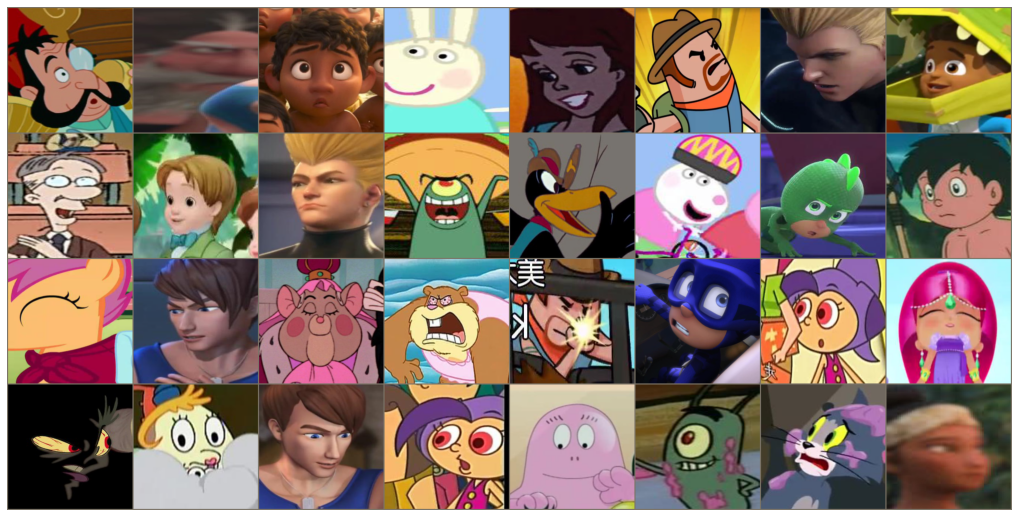

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # format as (X,Y,C)
    mean = np.array([0.485, 0.456, 0.406]) # imagenet
    std = np.array([0.229, 0.224, 0.225])  # imagenet
    inp = std * inp + mean # denormalise image
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(18,18))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out) # Optional title=([class_names[x] for x in classes])

### Train

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = []

    for epoch in range(num_epochs):
        result = {}
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            correct_females = 0
            correct_males = 0

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # inputs, labels = criterion.preprocess(inputs, labels) #dismax

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                for i, pred in enumerate(preds):
                  if len(class_names) == 3:
                    # has background class at index 0
                    if labels[i] == 1 and labels[i] == pred: 
                      correct_females += 1
                    if labels[i] == 2 and labels[i] == pred:
                      correct_males += 1
                  else:
                    if labels[i] == 0 and labels[i] == pred: 
                      correct_females += 1
                    if labels[i] == 1 and labels[i] == pred:
                      correct_males += 1
            
            if phase == 'train':
                # record & update learning rate
                result['lrs'] = get_lr(optimizer)
                scheduler.step()

            # for printing to command line
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]
            female_acc = correct_females / gender_dist[phase]['females']
            male_acc = correct_males / gender_dist[phase]['males']
            # for plotting
            result[phase+'_loss'] = epoch_loss
            result[phase+'_acc'] = epoch_acc
            result[phase+'_female_acc'] = female_acc
            result[phase+'_male_acc'] = male_acc

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save if the model has best accuracy till now
                torch.save(model, "output/model_best.pt")

            # print stats to command line
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            total_females = gender_dist[phase]['females']
            total_males = gender_dist[phase]['males']
            print(f'Female Acc: {correct_females}/{total_females} Male Acc: {correct_males}/{total_males}')
            print(f'Female Acc: {female_acc:.4f} Male Acc: {male_acc:.4f}')

            if phase == 'val':
                epoch_time = time.time() - epoch_start
                print('Time per epoch {:.0f}m {:.0f}s'.format(epoch_time // 60, epoch_time % 60))

        history.append(result)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    torch.save(history, "output/history.pt")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
# Load pretrained ResNetXX Model
# dismax: https://github.com/dlmacedo/distinction-maximization-loss
# import losses # dismax
from torchvision.models import ResNet18_Weights, ResNet50_Weights, ResNet101_Weights

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# model = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names), bias=False) # 512 -> 2 or 3 (BG) # , bias=False
# model.fc = losses.DisMaxLossFirstPart(num_ftrs, len(class_names)) # dismax
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# criterion = losses.DisMaxLossSecondPart(model.fc) # dismax

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9) #lr=0.003

# # Freeze until stem and first stage (included): https://raminnabati.com/post/002_adv_pytorch_freezing_layers/
# for idx, (name, module) in enumerate(model.named_children()):
#     if idx < 5:
#         for layer in module.children():
#             for param in layer.parameters():
#                 param.requires_grad = False

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=31, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 200, 250], gamma=0.1)

In [ ]:
# Set gender_dist
gender_dist = gender_dist
gender_dist

{'train': {'total': 23128, 'females': 11564, 'males': 11564},
 'val': {'total': 2790, 'females': 1395, 'males': 1395}}

In [ ]:
model, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=15) # num_epochs=30

Epoch 1/15
----------
train Loss: 0.5560 Acc: 0.7069
Female Acc: 7818/11564 Male Acc: 8532/11564
Female Acc: 0.6761 Male Acc: 0.7378
val Loss: 0.6782 Acc: 0.6211
Female Acc: 663/1395 Male Acc: 1070/1395
Female Acc: 0.4753 Male Acc: 0.7670
Time per epoch 1m 41s

Epoch 2/15
----------
train Loss: 0.4142 Acc: 0.8090
Female Acc: 9125/11564 Male Acc: 9586/11564
Female Acc: 0.7891 Male Acc: 0.8290
val Loss: 0.6472 Acc: 0.6602
Female Acc: 814/1395 Male Acc: 1028/1395
Female Acc: 0.5835 Male Acc: 0.7369
Time per epoch 1m 34s

Epoch 3/15
----------
train Loss: 0.3485 Acc: 0.8444
Female Acc: 9575/11564 Male Acc: 9955/11564
Female Acc: 0.8280 Male Acc: 0.8609
val Loss: 0.6431 Acc: 0.6735
Female Acc: 813/1395 Male Acc: 1066/1395
Female Acc: 0.5828 Male Acc: 0.7642
Time per epoch 1m 35s

Epoch 4/15
----------
train Loss: 0.3045 Acc: 0.8683
Female Acc: 9874/11564 Male Acc: 10208/11564
Female Acc: 0.8539 Male Acc: 0.8827
val Loss: 0.6366 Acc: 0.6846
Female Acc: 866/1395 Male Acc: 1044/1395
Female Acc

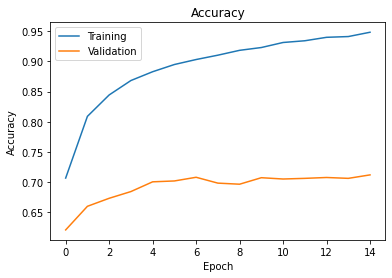

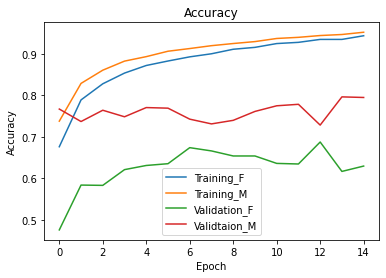

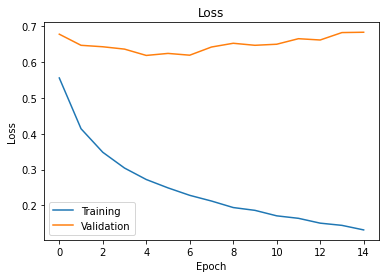

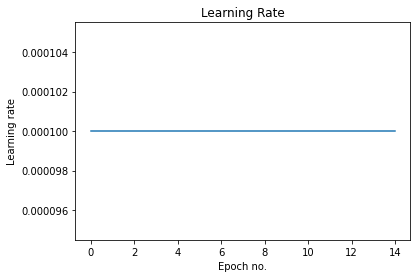

In [ ]:
def plot_accuracies(history):
    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.figure()
    plt.plot(train_accuracies)
    plt.plot(val_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy');
    plt.savefig('/content/output/accuracies.png')
plot_accuracies(history)

def plot_accuracies_gender(history):
    train_f_accuracies = [x['train_female_acc'] for x in history]
    train_m_accuracies = [x['train_male_acc'] for x in history]
    val_f_accuracies = [x['val_female_acc'] for x in history]
    val_m_accuracies = [x['val_male_acc'] for x in history]
    plt.figure()
    plt.plot(train_f_accuracies)
    plt.plot(train_m_accuracies)
    plt.plot(val_f_accuracies)
    plt.plot(val_m_accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training_F', 'Training_M', 'Validation_F', 'Validtaion_M'])
    plt.title('Accuracy');
    plt.savefig('/content/output/accuracies_gender.png')
plot_accuracies_gender(history)

def plot_losses(history):
    plt.figure()
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss')
    plt.savefig('/content/output/losses.png')
plot_losses(history)

def plot_lrs(history):
    plt.figure()
    lrs = [x.get('lrs') for x in history]
    plt.plot(lrs)
    plt.xlabel('Epoch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate')
    plt.savefig('/content/output/learning_rate.png')
plot_lrs(history)

In [ ]:
# Zip to MyDrive
!zip -r /content/drive/MyDrive/machine_learning/Models/Gender_Classification/ResNet18/021-4.zip output > /dev/null

### Visualise Results

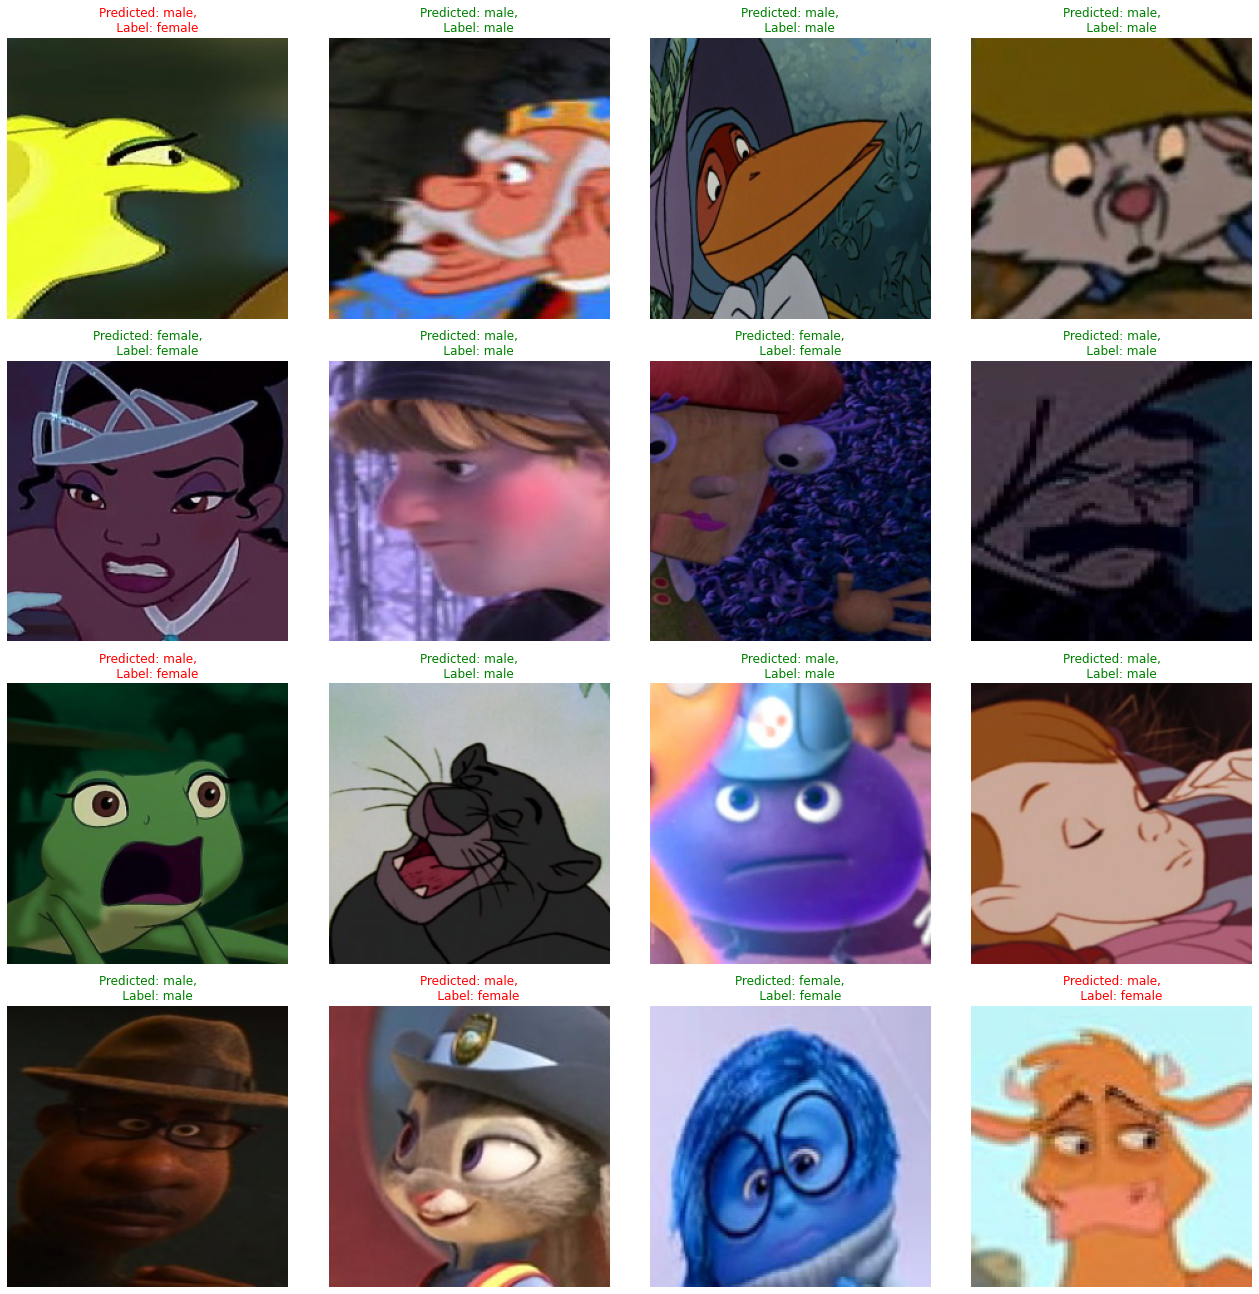

In [ ]:
def visualize_model(model, num_images=16):
    #was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(18,18*2)) # Adjust to make images close together
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 4, images_so_far)
                ax.axis('off')

                label = class_names[labels[j]]
                pred = class_names[preds[j]]
                c = 'g' if label == pred else 'r'
                ax.set_title(f'Predicted: {pred},\n     Label: {label}', color=c)
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean # denormalise image
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    #model.train(mode=was_training)
                    fig.tight_layout()
                    return
        #model.train(mode=was_training)

# Visualize predictions
visualize_model(model, num_images=16)
plt.savefig(data_dir+'_predictions.png')

### Grad Cam

In [ ]:
!pip install grad-cam > /dev/null

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import glob
import os

# Construct the CAM object once, and then re-use it on many images:
target_layers = [model.layer4[-1]] # for resnet18, resnet50
cam = GradCAM(model=model, target_layers=target_layers)

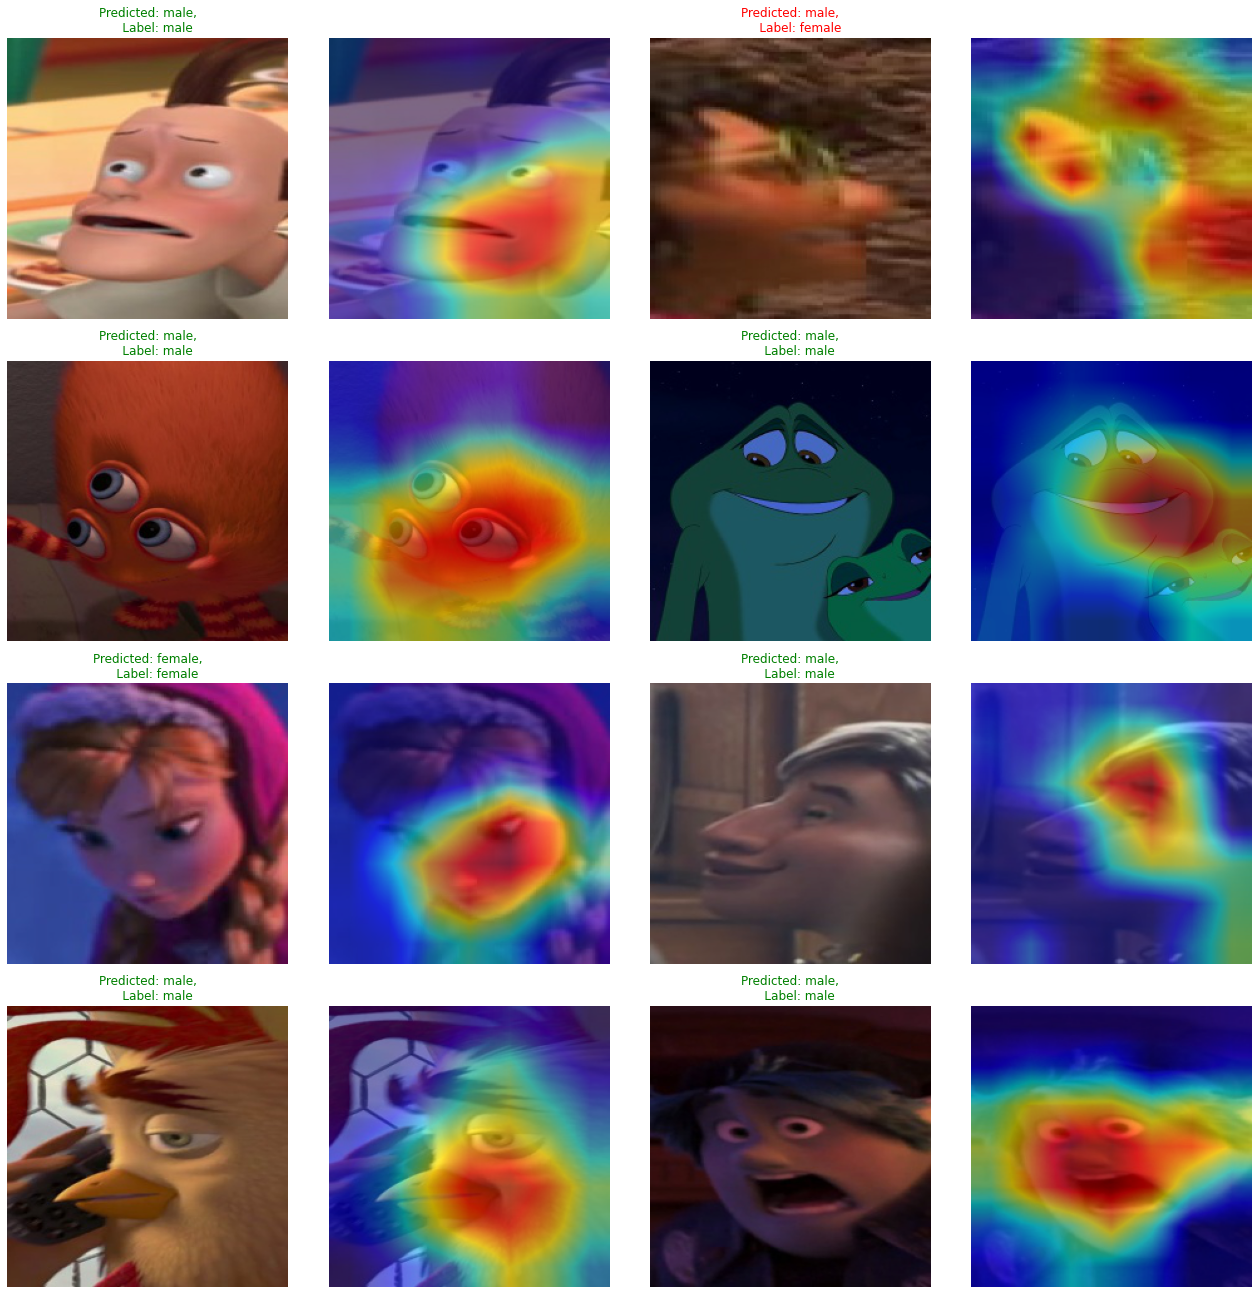

In [ ]:
def visualize_model(model, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(18,18*2)) # Adjust to make images close together
    for i, (inputs, labels) in enumerate(dataloaders['val']): # can't use grad_cam_dataloader['grad_cam'] because doesnn't use normalization
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 4, images_so_far)
            ax.axis('off')

            label = class_names[labels[j]]
            pred = class_names[preds[j]]
            c = 'g' if label == pred else 'r'
            ax.set_title(f'Predicted: {pred},\n     Label: {label}', color=c)

            inp = inputs.cpu().data[j]
            inp_np = inp.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp_np = std * inp_np + mean # denormalise image
            inp_float_np = np.clip(inp_np, 0, 1)
            ax.imshow(inp_float_np)

            images_so_far += 1
            ax = plt.subplot(num_images//2, 4, images_so_far)
            ax.axis('off')

            input_tensor = inp.to(device)
            input_tensor = input_tensor.unsqueeze(0)
            grayscale_cam = cam(input_tensor)
            grayscale_cam = grayscale_cam[0, :]
            cam_image = show_cam_on_image(inp_float_np, grayscale_cam, use_rgb=True)
            act_map = Image.fromarray(cam_image)
            ax.imshow(act_map)

            if images_so_far == num_images:
                fig.tight_layout()
                return

# Visualize Grad Cam
visualize_model(model, num_images=16)
plt.savefig(data_dir+'_gradcam.png')

### Misc

In [ ]:
# Check if params are frozen (False) or unfrozen (True)
for idx, (name, module) in enumerate(model.named_children()):
  print(f"Index: {idx} \nName: {name} \nModule: {module}")
  for layer in module.children():
    print(f"Module Child: {module.children()} \nLayer: {layer}")
    for param in layer.parameters():
      #print(f"Layer Parameter: {layer.parameters()}: \nParameter: {param}")
      print(f"Trainable: {param.requires_grad}")

In [ ]:
# stuff to try to add noise
class AddSaltPepperNoise(object):
    def __init__(self, amount=0.05):
        self.amount = amount
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
        torch.tensor(random_noise(img, mode='salt', amount=0.05))
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


def salt_paper_noise():
    for data in trainLoader:
        img, _ = data[0], data[1]
        salt_img = torch.tensor(random_noise(img, mode='salt', amount=0.05))
        save_noisy_image(salt_img, r"D:\ashishpatel26_github\Pytorch Learning\Noise_image\{dataset}_salt.png")
        break